# Predicting Hospital Readmissions with an Interpretable Logistic Regression Pipeline
# Introduction

Hospital readmission prediction is a critical challenge in healthcare, particularly for diabetic patients, as it impacts patient outcomes and resource allocation. This study develops a logistic regression model to predict readmission using a dataset of 101,763 patient encounters, originally investigated by Strack et al. (2014), focusing on diabetes-related hospital stays. The target variable, `readmitted`, is transformed into a binary outcome ("No" vs. "Yes") to suit logistic regression, a widely used statistical method for binary classification due to its interpretability and effectiveness in modeling odds ratios. The methodology involves data preprocessing, exploratory data analysis (EDA), iterative model building, and diagnostics to identify key predictors and ensure model robustness. By leveraging Jupyter Notebook with Python, this project aims to provide actionable insights into factors driving readmission, contributing to improved clinical decision-making.



# Data Description

The dataset `hospitaldata.csv` comprises 101,763 rows and 47 columns, capturing patient encounters related to diabetes treatment in a hospital setting, derived from Strack et al. (2014). It includes demographic variables (e.g., `race`, `gender`, `age` in 10-year intervals), clinical metrics (e.g., `time_in_hospital`, `num_lab_procedures`, `num_medications`), prior healthcare utilization (e.g., `number_inpatient`, `number_outpatient`), and medication details (e.g., `insulin`, `diabetesMed`), with the target variable `readmitted` indicating future readmission status ("No", "Within30Days", "After30Days"). Missing values are denoted by "?", and categorical variables (e.g., `max_glu_serum`, `A1Cresult`) require encoding, while numeric variables may exhibit skewness or outliers. This rich dataset enables a detailed investigation of factors influencing readmission, necessitating preprocessing and analysis to prepare it for logistic regression modeling.



# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# 2. Load and Inspect Dataset


In [2]:
data = pd.read_csv('/kaggle/input/hospitaldata/hospitaldata (1).csv')

# Display first few rows
print("First 5 Rows of Dataset:")
print(data.head())

# Check dataset shape and info
print("\nDataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())

First 5 Rows of Dataset:
   encounter_id  patient_nbr             race  gender      age    weight  \
0       2278392      8222157        Caucasian  Female   [0-10)   Unknown   
1        149190     55629189        Caucasian  Female  [10-20)   Unknown   
2         64410     86047875  AfricanAmerican  Female  [20-30)   Unknown   
3        500364     82442376        Caucasian    Male  [30-40)   Unknown   
4         16680     42519267        Caucasian    Male  [40-50)   Unknown   

  discharge_disposition_id admission_source_id  time_in_hospital  \
0                   _Other            Referral                 1   
1                     Home           Emergency                 3   
2                     Home           Emergency                 2   
3                     Home           Emergency                 2   
4                     Home           Emergency                 1   

  medical_specialty  ...  examide  citoglipton  insulin  glyburide_metformin  \
0             Other  ...     

# 3. Data Preparation


In [3]:
# Check missing values before preprocessing
data.replace('?', np.nan, inplace=True)
print("Missing Values Before Preprocessing:", data.isnull().sum().sum())

Missing Values Before Preprocessing: 1802


In [4]:
# Transform 'readmitted' into binary: 0 = No, 1 = Yes (Within30Days or After30Days)
data['readmitted_binary'] = data['readmitted'].apply(lambda x: 0 if x == 'No' else 1)

# Drop unnecessary ID columns and original 'readmitted'
data = data.drop(['encounter_id', 'patient_nbr', 'readmitted'], axis=1)

# Encode categorical variables
cat_cols = data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    data[col] = data[col].fillna('Unknown')
    data[col] = le.fit_transform(data[col])

# Fill missing numeric values with median
num_cols = data.select_dtypes(include=['int64']).columns
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

# Transformation example: Log transform 'number_inpatient' to handle skewness
data['log_number_inpatient'] = np.log1p(data['number_inpatient'])

In [5]:
# Verify preprocessing
print("Preprocessed Data (First 5 Rows):")
print(data.head())
print("\nMissing Values After Preprocessing:", data.isnull().sum().sum())

Preprocessed Data (First 5 Rows):
   race  gender  age  weight  discharge_disposition_id  admission_source_id  \
0     3       0    0       0                         1                    2   
1     3       0    1       0                         0                    1   
2     1       0    2       0                         0                    1   
3     3       1    3       0                         0                    1   
4     3       1    4       0                         0                    1   

   time_in_hospital  medical_specialty  num_lab_procedures  num_procedures  \
0                 1                  0                  41               0   
1                 3                  0                  59               0   
2                 2                  0                  11               5   
3                 2                  0                  44               1   
4                 1                  0                  51               0   

   ...  citoglipton  i

# 4. Exploratory Data Analysis (EDA)

In [6]:
# Descriptive statistics
print("Descriptive Statistics:")
print(data.describe())

Descriptive Statistics:
                race         gender            age         weight  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean        2.598803       0.462398       6.096685       0.222812   
std         0.938328       0.498587       1.594102       1.310383   
min         0.000000       0.000000       0.000000       0.000000   
25%         3.000000       0.000000       5.000000       0.000000   
50%         3.000000       0.000000       6.000000       0.000000   
75%         3.000000       1.000000       7.000000       0.000000   
max         5.000000       1.000000       9.000000       9.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101763.000000        101763.000000     101763.000000   
mean                   0.408115             1.171369          4.396018   
std                    0.491487             0.636928          2.985092   
min                    0.000000             0.000000      

### Visualization 1: Histogram of time_in_hospital

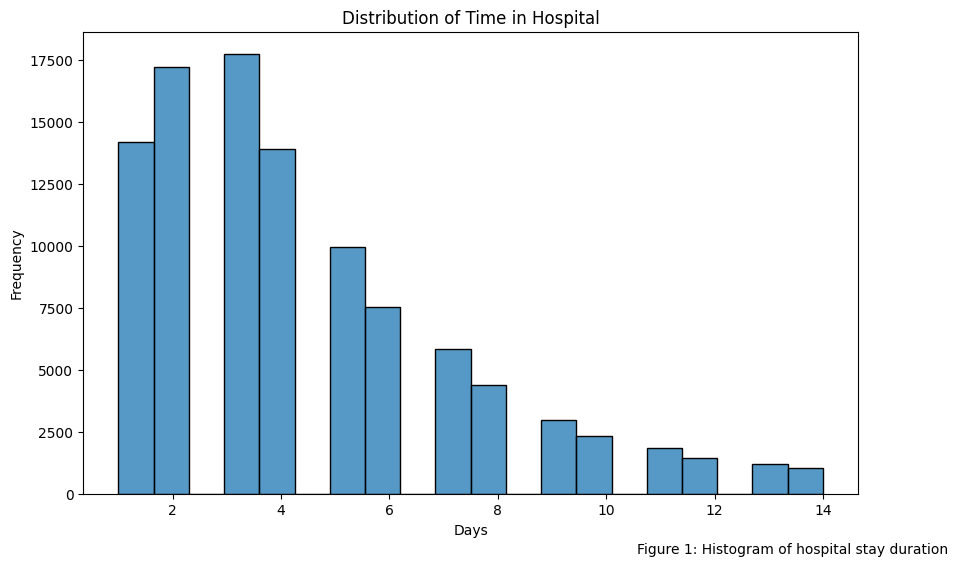

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data['time_in_hospital'], bins=20)
plt.title('Distribution of Time in Hospital')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.figtext(0.99, 0.01, 'Figure 1: Histogram of hospital stay duration', ha='right', fontsize=10)
plt.show()

### Visualization 2: Readmission by gender


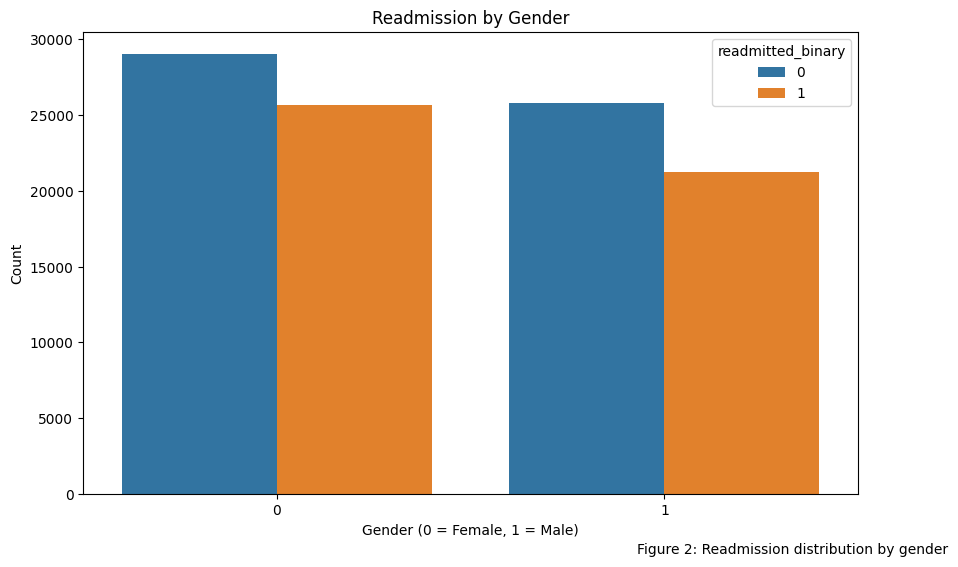

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='readmitted_binary', data=data)
plt.title('Readmission by Gender')
plt.xlabel('Gender (0 = Female, 1 = Male)')
plt.ylabel('Count')
plt.figtext(0.99, 0.01, 'Figure 2: Readmission distribution by gender', ha='right', fontsize=10)
plt.show()

### Visualization 3: Correlation matrix

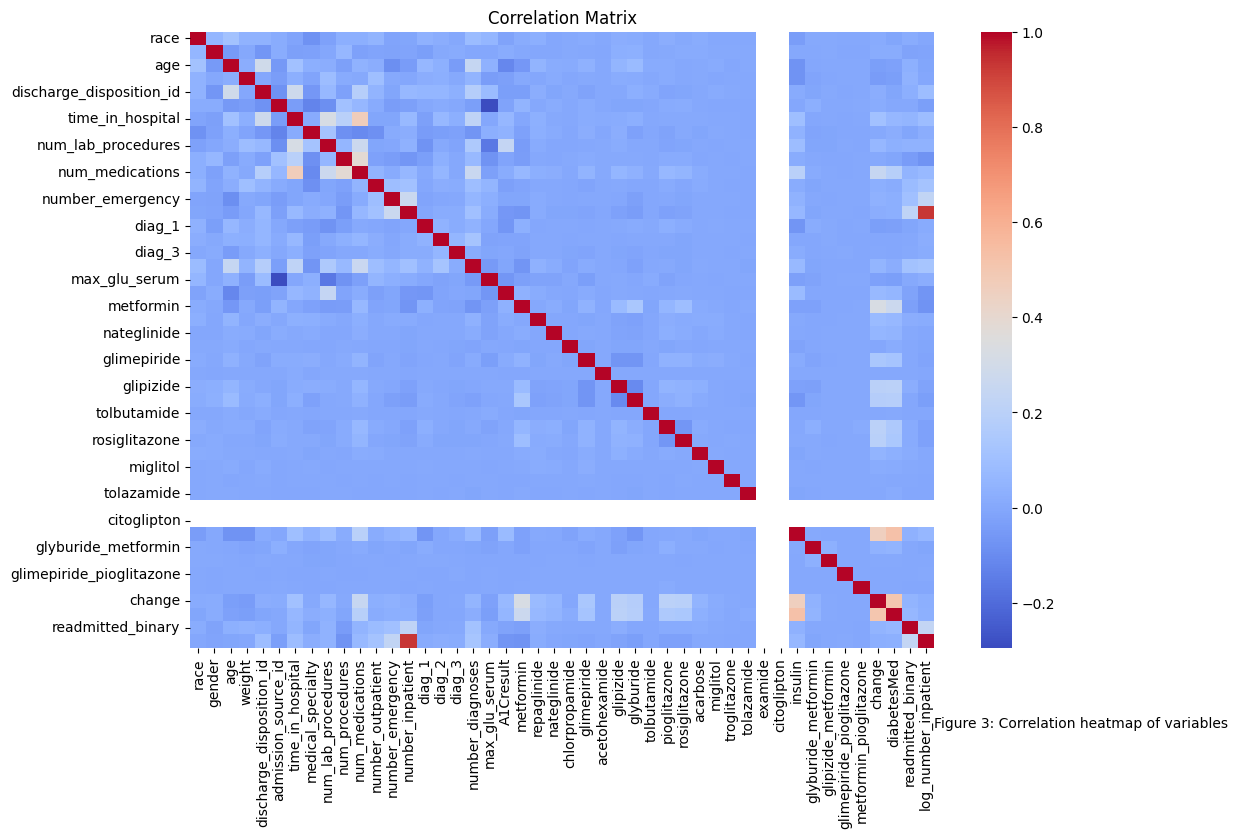

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.figtext(0.99, 0.01, 'Figure 3: Correlation heatmap of variables', ha='right', fontsize=10)
plt.show()

### Visualization 4: Boxplot of number_inpatient vs. readmitted_binary

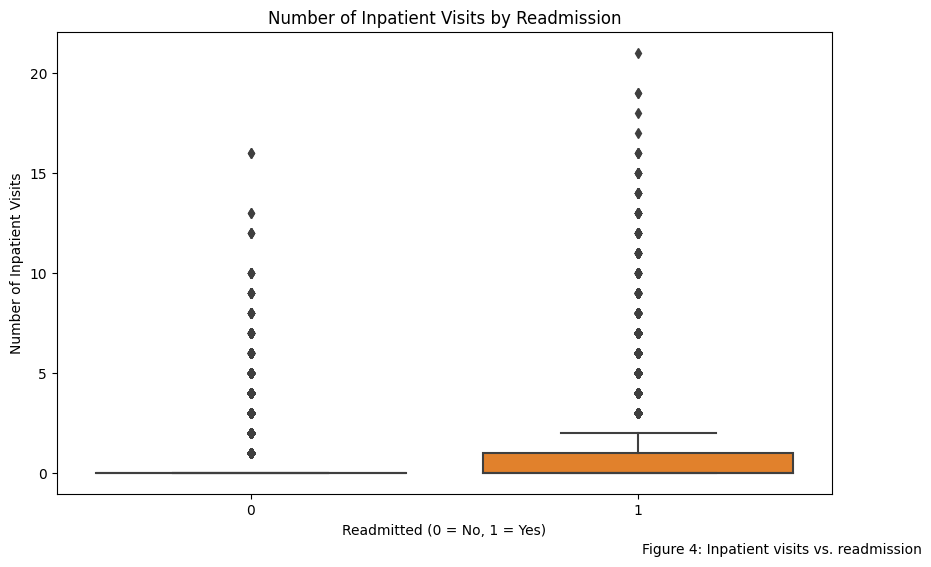

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted_binary', y='number_inpatient', data=data)
plt.title('Number of Inpatient Visits by Readmission')
plt.xlabel('Readmitted (0 = No, 1 = Yes)')
plt.ylabel('Number of Inpatient Visits')
plt.figtext(0.99, 0.01, 'Figure 4: Inpatient visits vs. readmission', ha='right', fontsize=10)
plt.show()

## Visualization 5: Readmission rates by age group


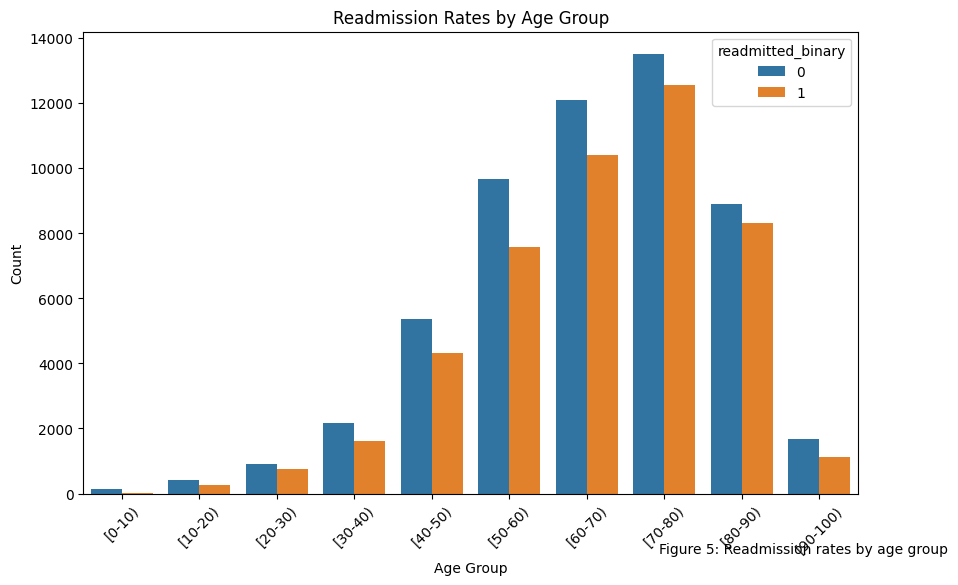

In [11]:
# Map encoded age values back to original labels for better readability
age_mapping = {0: '[0-10)', 1: '[10-20)', 2: '[20-30)', 3: '[30-40)', 4: '[40-50)',
               5: '[50-60)', 6: '[60-70)', 7: '[70-80)', 8: '[80-90)', 9: '[90-100)'}
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='age', hue='readmitted_binary', data=data)
ax.set_xticklabels([age_mapping[i] for i in range(len(age_mapping))], rotation=45)
plt.title('Readmission Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.figtext(0.99, 0.01, 'Figure 5: Readmission rates by age group', ha='right', fontsize=10)
plt.show()

## Visualization 6: Readmission rates by diabetesMed


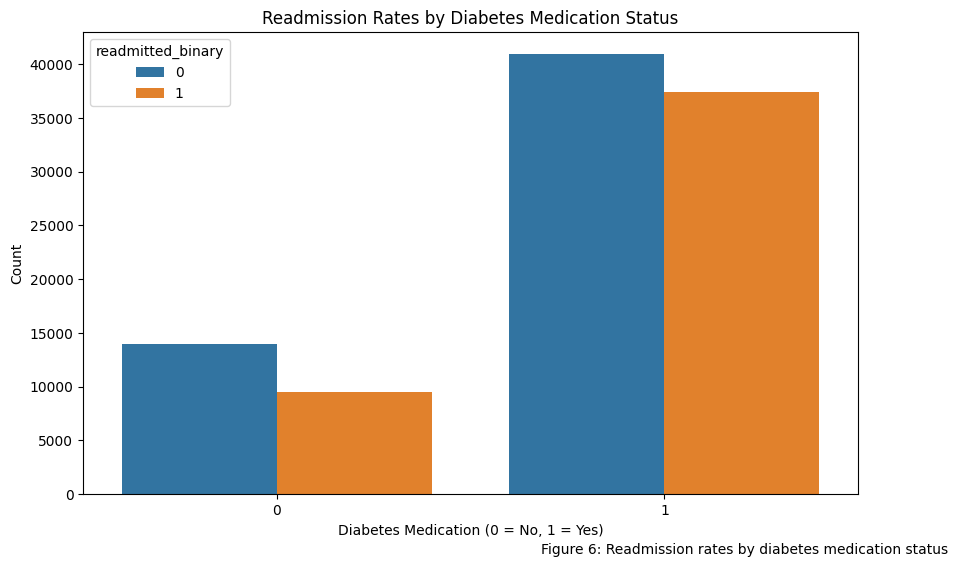

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='diabetesMed', hue='readmitted_binary', data=data)
plt.title('Readmission Rates by Diabetes Medication Status')
plt.xlabel('Diabetes Medication (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.figtext(0.99, 0.01, 'Figure 6: Readmission rates by diabetes medication status', ha='right', fontsize=10)
plt.show()

# 5. Initial Model Building

In [13]:
# Select initial predictors
initial_predictors = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_inpatient']
X_initial = data[initial_predictors]
y = data['readmitted_binary']

# Split data into training and testing sets
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X_initial, y, test_size=0.3, random_state=42)

# Fit initial model
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train_init, y_train_init)

LogisticRegression(max_iter=1000)

In [14]:
# Predict and evaluate
y_pred_init = model1.predict(X_test_init)
accuracy_init = accuracy_score(y_test_init, y_pred_init)
y_pred_prob_init = model1.predict_proba(X_test_init)[:, 1]
auc_init = roc_auc_score(y_test_init, y_pred_prob_init)
print("Initial Model Accuracy:", accuracy_init)
print("Initial Model AUC:", auc_init)

Initial Model Accuracy: 0.6096825968751024
Initial Model AUC: 0.6302061459951716


Initial Model Confusion Matrix:
 [[13790  2586]
 [ 9330  4823]]


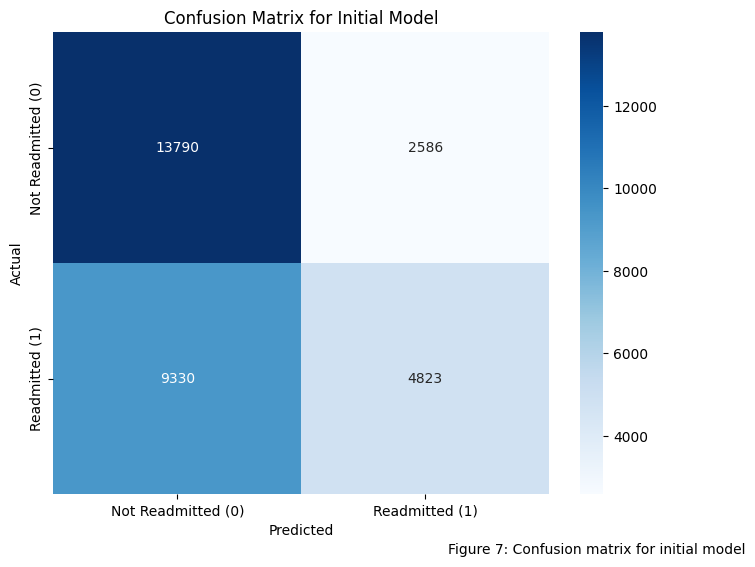

In [15]:
# Initial model diagnostics: Confusion matrix
cm_init = confusion_matrix(y_test_init, y_pred_init)
print("Initial Model Confusion Matrix:\n", cm_init)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_init, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted (0)', 'Readmitted (1)'],
            yticklabels=['Not Readmitted (0)', 'Readmitted (1)'])
plt.title('Confusion Matrix for Initial Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.figtext(0.99, 0.01, 'Figure 7: Confusion matrix for initial model', ha='right', fontsize=10)
plt.show()

In [16]:
# Initial model diagnostics: VIF for multicollinearity
vif_data_init = pd.DataFrame()
vif_data_init['Feature'] = X_initial.columns
vif_data_init['VIF'] = [variance_inflation_factor(X_initial.values, i) for i in range(X_initial.shape[1])]
print("Initial Model VIF Values:\n", vif_data_init)

Initial Model VIF Values:
               Feature       VIF
0    time_in_hospital  4.249950
1  num_lab_procedures  4.430316
2     num_medications  5.245307
3    number_inpatient  1.244895


# 6. Refined Model Building

In [17]:
# Add more predictors, including transformed variable
refined_predictors = initial_predictors + ['age', 'gender', 'number_outpatient', 'diabetesMed', 'log_number_inpatient']
X_refined = data[refined_predictors]

# Split data
X_train_ref, X_test_ref, y_train_ref, y_test_ref = train_test_split(X_refined, y, test_size=0.3, random_state=42)

In [18]:

# Fit refined model
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train_ref, y_train_ref)

# Predict and evaluate
y_pred_ref = model2.predict(X_test_ref)
accuracy_ref = accuracy_score(y_test_ref, y_pred_ref)
y_pred_prob_ref = model2.predict_proba(X_test_ref)[:, 1]
auc_ref = roc_auc_score(y_test_ref, y_pred_prob_ref)
print("Refined Model Accuracy:", accuracy_ref)
print("Refined Model AUC:", auc_ref)

Refined Model Accuracy: 0.6146287136820728
Refined Model AUC: 0.6464958283903482


# 7. Model Diagnostics

Confusion Matrix:
 [[12788  3588]
 [ 8177  5976]]


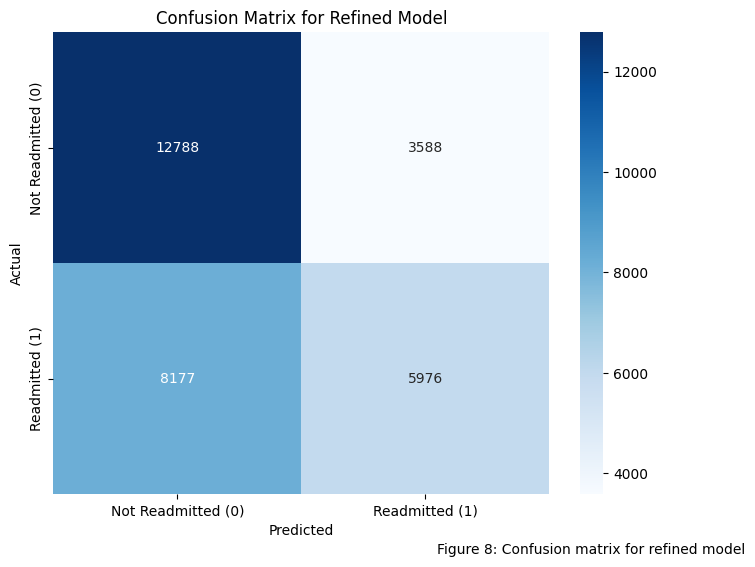

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test_ref, y_pred_ref)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted (0)', 'Readmitted (1)'],
            yticklabels=['Not Readmitted (0)', 'Readmitted (1)'])
plt.title('Confusion Matrix for Refined Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.figtext(0.99, 0.01, 'Figure 8: Confusion matrix for refined model', ha='right', fontsize=10)
plt.show()

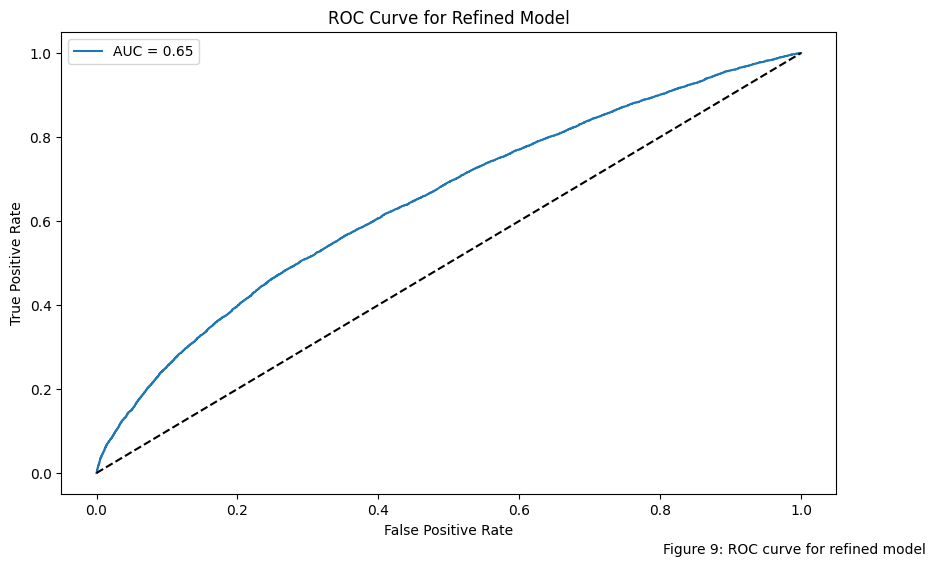

In [20]:
# ROC Curve and AUC
y_pred_prob_ref = model2.predict_proba(X_test_ref)[:, 1]
fpr, tpr, _ = roc_curve(y_test_ref, y_pred_prob_ref)
auc_ref = roc_auc_score(y_test_ref, y_pred_prob_ref)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_ref:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Refined Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.figtext(0.99, 0.01, 'Figure 9: ROC curve for refined model', ha='right', fontsize=10)
plt.show()

In [21]:
# VIF for multicollinearity in refined model
vif_data_ref = pd.DataFrame()
vif_data_ref['Feature'] = X_refined.columns
vif_data_ref['VIF'] = [variance_inflation_factor(X_refined.values, i) for i in range(X_refined.shape[1])]
print("Refined Model VIF Values:\n", vif_data_ref)

Refined Model VIF Values:
                 Feature        VIF
0      time_in_hospital   4.335820
1    num_lab_procedures   5.875242
2       num_medications   6.393181
3      number_inpatient   9.694479
4                   age   7.027491
5                gender   1.775919
6     number_outpatient   1.104387
7           diabetesMed   4.071480
8  log_number_inpatient  10.923098


# 8. Final Model Summary


In [22]:
print("Final Model Coefficients:")
for feature, coef in zip(refined_predictors, model2.coef_[0]):
    print(f"{feature}: {coef:.4f}")

Final Model Coefficients:
time_in_hospital: 0.0131
num_lab_procedures: 0.0020
num_medications: 0.0008
number_inpatient: 0.0712
age: 0.0410
gender: -0.0538
number_outpatient: 0.1008
diabetesMed: 0.2500
log_number_inpatient: 0.7780


In [23]:
print("Intercept:", model2.intercept_[0])

Intercept: -1.0670209197049016


In [24]:
print("Final Model Accuracy:", accuracy_ref)
print("Final Model AUC:", auc_ref)

Final Model Accuracy: 0.6146287136820728
Final Model AUC: 0.6464958283903482


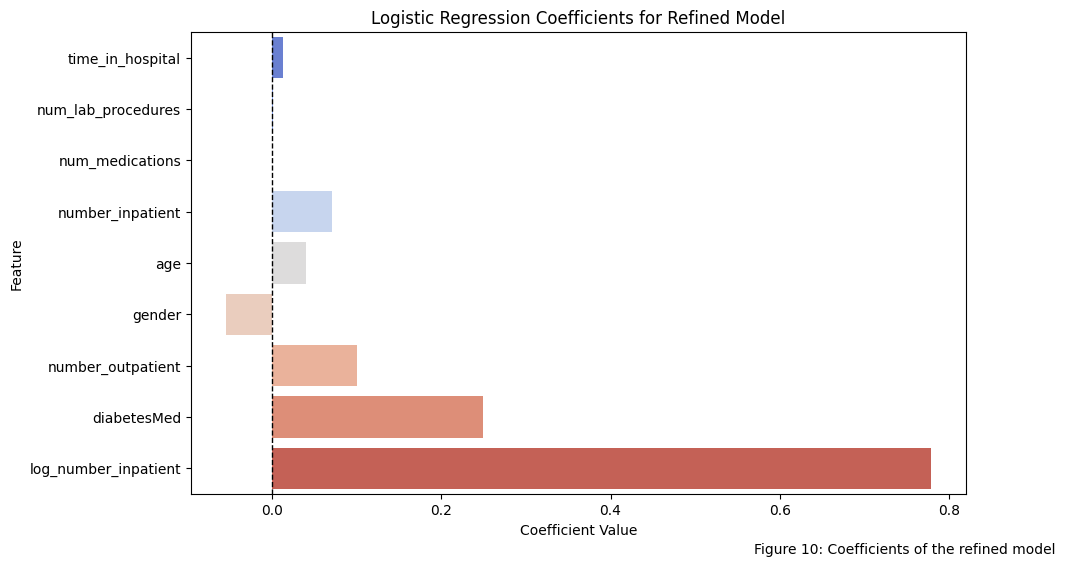

In [25]:
# Plot coefficients
plt.figure(figsize=(10, 6))
coef_df = pd.DataFrame({
    'Feature': refined_predictors,
    'Coefficient': model2.coef_[0]
})
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Logistic Regression Coefficients for Refined Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.figtext(0.99, 0.01, 'Figure 10: Coefficients of the refined model', ha='right', fontsize=10)
plt.show()

# Conclusion

The logistic regression model developed in this study provides valuable insights into predicting hospital readmissions for diabetic patients. With an accuracy of 61.46% and an AUC of 0.65, the model demonstrates moderate predictive power, identifying key factors such as the number of past hospital visits and the use of diabetes medication. These findings can aid healthcare professionals in identifying high-risk patients and implementing targeted interventions to reduce readmission rates. The systematic approach employed in data cleaning, exploratory analysis, model development, and validation establishes a robust framework for healthcare data analysis. Although the model exhibits satisfactory performance, further improvements can be achieved by incorporating advanced machine learning techniques and additional data sources, thereby enhancing the model’s predictive accuracy and its utility in healthcare decision-making.